# Classifying MNIST with a simple model and quantum embeddings

Inspired by:  https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch

Useful imports

In [8]:
# for the Boson Sampler
import perceval as pcvl
#import perceval.providers.scaleway as scw  # Uncomment to allow running on scaleway

# for the machine learning model
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from boson_sampler import BosonSampler
from utils import MNIST_partial, accuracy, plot_training_metrics
from model import *
from pqnn_model import QuantumLayer, OutputMappingStrategy
import math

## Definition of the Boson Sampler

In [9]:
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()

#to display it
# pcvl.pdisplay(bs.create_circuit())
# define device to run the model

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE = {device}')

DEVICE = cpu


## Dataset : a subset of MNIST dataset

In [ ]:
# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(split = 'train')
val_dataset = MNIST_partial(split='val')

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

In [11]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([10, 1, 28, 28])
Image label dimensions: torch.Size([10])


## Training loop

In [12]:
def train_model(model, optimizer, num_epochs, train_loader, val_loader, device):
    criterion = nn.CrossEntropyLoss()
    history_train_accuracy, history_val_accuracy, history_train_loss, history_val_loss = [],[],[],[]
    for epoch in range(num_epochs):
        # training
        model.train()
        train_loss_epoch = []
        train_acc_epoch = []
        for step, batch in enumerate(tqdm(train_loader)):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss_epoch.append(loss.item())
            acc = accuracy(output, labels)
            train_acc_epoch.append(acc)
        model.eval()
        val_loss_epoch = []
        val_acc_epoch = []
        for step, batch in enumerate(tqdm(val_loader)):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss_epoch.append(loss.item())
            acc = accuracy(output, labels)
            val_acc_epoch.append(acc)
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {sum(train_loss_epoch)/len(train_loss_epoch):.4f}, Val Loss: {sum(val_loss_epoch)/len(val_loss_epoch):.4f}, Train Acc: {sum(train_acc_epoch)/len(train_acc_epoch):.4f}, Val Acc: {sum(val_acc_epoch)/len(val_acc_epoch):.4f}")
        history_train_loss.append(sum(train_loss_epoch)/len(train_loss_epoch))
        history_train_accuracy.append(sum(train_acc_epoch)/len(train_acc_epoch))
        history_val_loss.append(sum(val_loss_epoch)/len(val_loss_epoch))
        history_val_accuracy.append(sum(val_acc_epoch)/len(val_acc_epoch))
    plot_training_metrics(history_train_accuracy, history_val_accuracy, history_train_loss, history_val_loss)


    # validation

## Model definition

The goal is to perform transfer learning from task A to MNIST. First, we try with task A being ImageNet. Therefore :
* We take a ResNet18 pretrained on ImageNet
* Classical comparison : we train the input layer and the last FC layer to classify MNIST
* Quantum training : the FC layer is replaced by a QuantumLayer and a linear layer to map the output of the QuantumLayer to the 10 classes

### Initialisation of the model

In [13]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

In [14]:
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Classical Transfer Learning

In [15]:
MODES = 12
# change first conv1 to take 1 input channel as input
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


# change last FC layer to map to the 10 classes of MNIST
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=MODES, bias = True), nn.Linear(in_features=MODES, out_features=10, bias = True))
# almost equivalent to LoRA weights decomposition: instead of having 512x10 weights (+ bias), we have (512*MODES)+(MODES*10) = MODES(512+1


100%|██████████| 60/60 [00:01<00:00, 47.96it/s]


Epoch 1/5: Train Loss: 0.9428, Val Loss: 0.3328, Train Acc: 0.7197, Val Acc: 0.9000


100%|██████████| 60/60 [00:01<00:00, 47.96it/s]


Epoch 2/5: Train Loss: 0.3830, Val Loss: 0.2050, Train Acc: 0.8920, Val Acc: 0.9417


100%|██████████| 60/60 [00:01<00:00, 38.69it/s]


Epoch 3/5: Train Loss: 0.2515, Val Loss: 0.1758, Train Acc: 0.9318, Val Acc: 0.9550


100%|██████████| 60/60 [00:01<00:00, 43.01it/s]


Epoch 4/5: Train Loss: 0.1991, Val Loss: 0.1613, Train Acc: 0.9460, Val Acc: 0.9567


100%|██████████| 60/60 [00:01<00:00, 45.67it/s]


Epoch 5/5: Train Loss: 0.1433, Val Loss: 0.1026, Train Acc: 0.9613, Val Acc: 0.9750


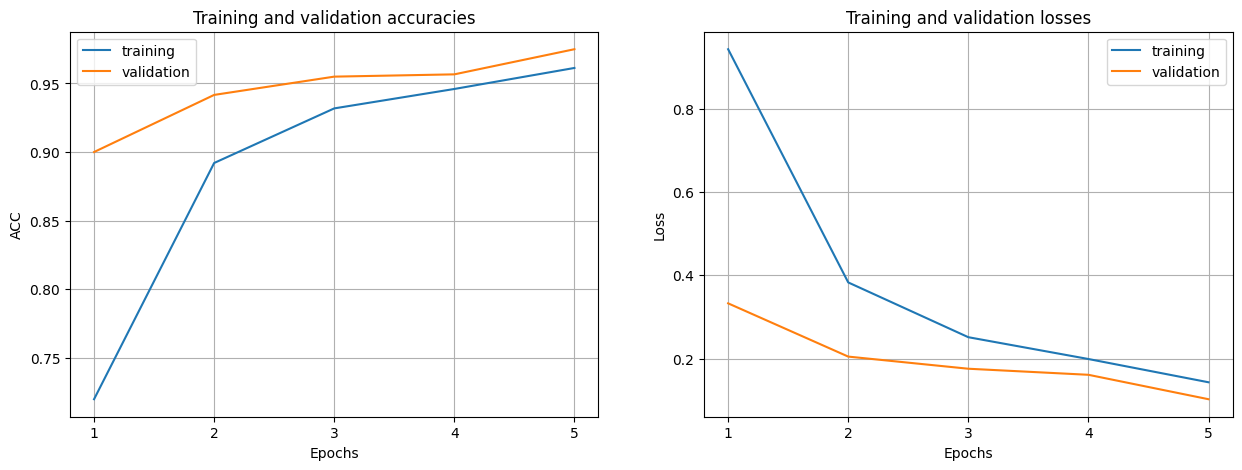

In [16]:
# the model is fully trained
model = pretrained_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model,optimizer,5,train_loader,val_loader, device)

100%|██████████| 60/60 [00:00<00:00, 136.14it/s]


Epoch 1/5: Train Loss: 1.5749, Val Loss: 1.2459, Train Acc: 0.4585, Val Acc: 0.6150


100%|██████████| 60/60 [00:00<00:00, 140.09it/s]


Epoch 2/5: Train Loss: 1.0863, Val Loss: 1.0065, Train Acc: 0.6347, Val Acc: 0.7050


100%|██████████| 60/60 [00:00<00:00, 140.05it/s]


Epoch 3/5: Train Loss: 0.9603, Val Loss: 0.8799, Train Acc: 0.6862, Val Acc: 0.7200


100%|██████████| 60/60 [00:00<00:00, 140.07it/s]


Epoch 4/5: Train Loss: 0.9142, Val Loss: 0.7117, Train Acc: 0.6983, Val Acc: 0.7917


100%|██████████| 60/60 [00:00<00:00, 141.06it/s]


Epoch 5/5: Train Loss: 0.8183, Val Loss: 0.7363, Train Acc: 0.7360, Val Acc: 0.7583


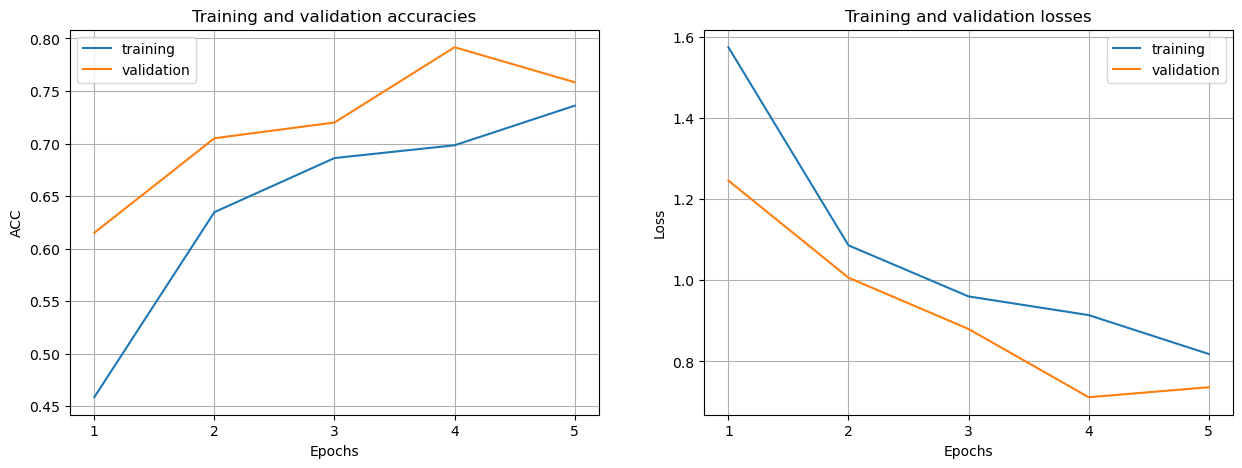

In [ ]:
# we only train the first conv and fc layer
MODES = 12

pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# change first conv1 to take 1 input channel as input
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# change last FC layer to map to the 10 classes of MNIST
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=MODES, bias = True), nn.Linear(in_features=MODES, out_features=10, bias = True))

model = pretrained_model.to(device)
model.requires_grad = False
model.conv1.requires_grad = True
model.fc.requires_grad = True

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)
train_model(model,optimizer,5,train_loader,val_loader, device)


### Quantum Transfer Learning

In [ ]:
MODES = 8
hidden_dim = 128

# change first conv1 to take 1 input channel as input
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


# first, we consider we have as may modes as features
encoding_circuit = pcvl.Circuit(MODES)
for i in range(0,MODES,2):
    encoding_circuit.add(i , pcvl.BS())
for i in range(1,MODES-1,2):
    encoding_circuit.add(i , pcvl.BS())
for i in range(hidden_dim):
    feat = pcvl.P(f"feat-{i + 1}")
    encoding_circuit.add(i % MODES, pcvl.PS(feat))
pcvl.pdisplay(encoding_circuit)
trainable_circuit = pcvl.GenericInterferometer(MODES, lambda i: (pcvl.BS() #theta=pcvl.P(f"bs_1_{i}")
                                                             .add(0, pcvl.PS(pcvl.P(f"phase_train_1_{i}")))
                                                             .add(0, pcvl.BS()) #theta=pcvl.P(f"bs_1_{i}")
                                                             .add(0, pcvl.PS(pcvl.P(f"phase_train_2_{i}")))
                                                             )
                                          )
circuit = pcvl.Circuit(MODES)
circuit.add(0, encoding_circuit, merge=True)
circuit.add(0, trainable_circuit, merge=True)

input_state = [(i + 1) % 2 for i in range(MODES)]
photon_count = sum(input_state)
qlayer = QuantumLayer(
            input_size=hidden_dim,
            output_size=10, # but we do not use it
            circuit = circuit,
            input_state = input_state,
            trainable_parameters= [p.name for p in circuit.get_parameters() if not p.name.startswith("feat")],
            output_mapping_strategy=OutputMappingStrategy.LINEAR)

# change last FC layer to QLayer + linear layer
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=hidden_dim, bias=True),
                                    qlayer)


===>n_thetas 56


In [ ]:
model = pretrained_model.to(device)

#model.requires_grad = False
#model.conv1.requires_grad = True
#model.fc.requires_grad = True

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.01)
train_model(model,optimizer,5,train_loader,val_loader, device)

100%|██████████| 60/60 [00:03<00:00, 18.17it/s]


Epoch 1/5: Train Loss: 2.3046, Val Loss: 2.3037, Train Acc: 0.1132, Val Acc: 0.1250


 33%|███▎      | 198/600 [00:24<00:49,  8.11it/s]

## Training loop

## Model training

In [ ]:
# end session if needed
if session is not None:
    session.stop()